In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14, 1)
test_x = test_x.reshape(len(test_x), 10, 14, 1)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 10, 14, 1), (20000, 14))


# define parameters

In [5]:
learning_rate = 0.0001
training_iters = 8000000
batch_size = 1000
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 0.75 # Dropout, probability to keep units

# network config

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling)
    conv3 = maxpool2d(conv3, k=2)
    print(conv3.shape)

    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    print(fc1.shape)

    # Output, class prediction
    fc2 = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    print(fc2.shape)
    return fc2

# Store layers weight & bias
weights = {
    # 3x4 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([3, 4, 1, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # 3x4 conv, 64 inputs, 64 outputs
    'wc3': tf.Variable(tf.random_normal([3, 4, 64, 64])),
    # fully connected, 2*2*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*64, 1024])),
    # 1024 inputs, 14 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bc3': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [7]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 32)
(?, 3, 4, 64)
(?, 2, 2, 64)
(?, 1024)
(?, 14)


# train and test

In [8]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #1000: Batch Loss = 119201.046875, Accuracy = 0.148000001907
Performance on test set: Training epochs #1000, Batch Loss = 52239.375, Accuracy = 0.366000026464
Training epochs #20000: Batch Loss = 144729.109375, Accuracy = 0.070000000298
Performance on test set: Training epochs #20000, Batch Loss = 171877.25, Accuracy = 0.0100000007078
Training epochs #40000: Batch Loss = 148662.046875, Accuracy = 0.015000000596
Performance on test set: Training epochs #40000, Batch Loss = 113231.367188, Accuracy = 0.0100000007078
Training epochs #60000: Batch Loss = 89231.421875, Accuracy = 0.0509999990463
Performance on test set: Training epochs #60000, Batch Loss = 43149.5742188, Accuracy = 0.00600000005215
Training epochs #80000: Batch Loss = 42067.367188, Accuracy = 0.26700001955
Performance on test set: Training epochs #80000, Batch Loss = 5520.36328125, Accuracy = 0.805000066757
Training epochs #100000: Batch Loss = 107523.117188, Accuracy = 0.0630000010133
Performance on test set

Training epochs #920000: Batch Loss = 8410.690430, Accuracy = 0.680999994278
Performance on test set: Training epochs #920000, Batch Loss = 1449.27966309, Accuracy = 0.943000078201
Training epochs #940000: Batch Loss = 5679.507812, Accuracy = 0.795000076294
Performance on test set: Training epochs #940000, Batch Loss = 2340.73950195, Accuracy = 0.943000078201
Training epochs #960000: Batch Loss = 4298.749512, Accuracy = 0.876999974251
Performance on test set: Training epochs #960000, Batch Loss = 2777.24169922, Accuracy = 0.942999958992
Training epochs #980000: Batch Loss = 40798.246094, Accuracy = 0.224000006914
Performance on test set: Training epochs #980000, Batch Loss = 1396.99633789, Accuracy = 0.942999958992
Training epochs #1000000: Batch Loss = 8651.337891, Accuracy = 0.680999994278
Performance on test set: Training epochs #1000000, Batch Loss = 1378.07214355, Accuracy = 0.943000078201
Training epochs #1020000: Batch Loss = 5202.205078, Accuracy = 0.827000081539
Performance on

Training epochs #1820000: Batch Loss = 2789.750977, Accuracy = 0.861999988556
Performance on test set: Training epochs #1820000, Batch Loss = 1166.34692383, Accuracy = 0.954999983311
Training epochs #1840000: Batch Loss = 2070.239746, Accuracy = 0.902000010014
Performance on test set: Training epochs #1840000, Batch Loss = 1362.21044922, Accuracy = 0.955000042915
Training epochs #1860000: Batch Loss = 23153.378906, Accuracy = 0.28100001812
Performance on test set: Training epochs #1860000, Batch Loss = 724.145507812, Accuracy = 0.942999958992
Training epochs #1880000: Batch Loss = 4032.448242, Accuracy = 0.776000022888
Performance on test set: Training epochs #1880000, Batch Loss = 727.24810791, Accuracy = 0.955000042915
Training epochs #1900000: Batch Loss = 2807.733398, Accuracy = 0.85900002718
Performance on test set: Training epochs #1900000, Batch Loss = 1103.0715332, Accuracy = 0.954999983311
Training epochs #1920000: Batch Loss = 2287.884521, Accuracy = 0.888000011444
Performanc

Training epochs #2720000: Batch Loss = 1100.821533, Accuracy = 0.929000020027
Performance on test set: Training epochs #2720000, Batch Loss = 829.30279541, Accuracy = 0.954999983311
Training epochs #2740000: Batch Loss = 15735.696289, Accuracy = 0.320999979973
Performance on test set: Training epochs #2740000, Batch Loss = 485.611999512, Accuracy = 0.961000025272
Training epochs #2760000: Batch Loss = 2266.117188, Accuracy = 0.808000028133
Performance on test set: Training epochs #2760000, Batch Loss = 510.311737061, Accuracy = 0.961000025272
Training epochs #2780000: Batch Loss = 1683.571045, Accuracy = 0.898999989033
Performance on test set: Training epochs #2780000, Batch Loss = 670.047119141, Accuracy = 0.961000084877
Training epochs #2800000: Batch Loss = 1025.859131, Accuracy = 0.927999973297
Performance on test set: Training epochs #2800000, Batch Loss = 770.750305176, Accuracy = 0.954999983311
Training epochs #2820000: Batch Loss = 14151.131836, Accuracy = 0.348999977112
Perfor

Training epochs #3620000: Batch Loss = 9308.692383, Accuracy = 0.429000020027
Performance on test set: Training epochs #3620000, Batch Loss = 278.326721191, Accuracy = 0.961000025272
Training epochs #3640000: Batch Loss = 1274.880859, Accuracy = 0.870999991894
Performance on test set: Training epochs #3640000, Batch Loss = 338.408630371, Accuracy = 0.961000025272
Training epochs #3660000: Batch Loss = 1099.346924, Accuracy = 0.918000102043
Performance on test set: Training epochs #3660000, Batch Loss = 465.250427246, Accuracy = 0.961000025272
Training epochs #3680000: Batch Loss = 670.441650, Accuracy = 0.943000078201
Performance on test set: Training epochs #3680000, Batch Loss = 490.412353516, Accuracy = 0.961000025272
Training epochs #3700000: Batch Loss = 8760.977539, Accuracy = 0.43599998951
Performance on test set: Training epochs #3700000, Batch Loss = 250.969696045, Accuracy = 0.961000025272
Training epochs #3720000: Batch Loss = 1315.329346, Accuracy = 0.87399995327
Performanc

Training epochs #4520000: Batch Loss = 749.871460, Accuracy = 0.898000001907
Performance on test set: Training epochs #4520000, Batch Loss = 190.763809204, Accuracy = 0.967999994755
Training epochs #4540000: Batch Loss = 637.437622, Accuracy = 0.935000002384
Performance on test set: Training epochs #4540000, Batch Loss = 259.391326904, Accuracy = 0.961000084877
Training epochs #4560000: Batch Loss = 400.767426, Accuracy = 0.962000012398
Performance on test set: Training epochs #4560000, Batch Loss = 251.876480103, Accuracy = 0.961000025272
Training epochs #4580000: Batch Loss = 6152.407715, Accuracy = 0.513999998569
Performance on test set: Training epochs #4580000, Batch Loss = 149.171707153, Accuracy = 0.981999993324
Training epochs #4600000: Batch Loss = 630.256348, Accuracy = 0.923999965191
Performance on test set: Training epochs #4600000, Batch Loss = 178.754440308, Accuracy = 0.967999994755
Training epochs #4620000: Batch Loss = 623.813477, Accuracy = 0.939000070095
Performance 

Training epochs #5420000: Batch Loss = 391.657928, Accuracy = 0.952000081539
Performance on test set: Training epochs #5420000, Batch Loss = 119.02696228, Accuracy = 0.967999994755
Training epochs #5440000: Batch Loss = 249.770187, Accuracy = 0.962999999523
Performance on test set: Training epochs #5440000, Batch Loss = 94.8289489746, Accuracy = 0.981999993324
Training epochs #5460000: Batch Loss = 3945.652344, Accuracy = 0.574000060558
Performance on test set: Training epochs #5460000, Batch Loss = 105.585044861, Accuracy = 0.990000009537
Training epochs #5480000: Batch Loss = 522.327209, Accuracy = 0.92300003767
Performance on test set: Training epochs #5480000, Batch Loss = 99.472114563, Accuracy = 0.990000069141
Training epochs #5500000: Batch Loss = 378.634186, Accuracy = 0.956000030041
Performance on test set: Training epochs #5500000, Batch Loss = 117.005760193, Accuracy = 0.967999994755
Training epochs #5520000: Batch Loss = 187.401215, Accuracy = 0.961000025272
Performance on 

Training epochs #6340000: Batch Loss = 2824.987305, Accuracy = 0.645999968052
Performance on test set: Training epochs #6340000, Batch Loss = 84.9288635254, Accuracy = 0.990000009537
Training epochs #6360000: Batch Loss = 251.158096, Accuracy = 0.95400005579
Performance on test set: Training epochs #6360000, Batch Loss = 74.6710662842, Accuracy = 0.991000056267
Training epochs #6380000: Batch Loss = 208.740189, Accuracy = 0.957000017166
Performance on test set: Training epochs #6380000, Batch Loss = 55.4029846191, Accuracy = 0.990000009537
Training epochs #6400000: Batch Loss = 121.575653, Accuracy = 0.978999972343
Performance on test set: Training epochs #6400000, Batch Loss = 51.4704284668, Accuracy = 0.983000040054
Training epochs #6420000: Batch Loss = 3003.757568, Accuracy = 0.632999956608
Performance on test set: Training epochs #6420000, Batch Loss = 81.4216842651, Accuracy = 0.990000009537
Training epochs #6440000: Batch Loss = 292.111847, Accuracy = 0.95400005579
Performance o

Training epochs #7260000: Batch Loss = 171.829895, Accuracy = 0.973999977112
Performance on test set: Training epochs #7260000, Batch Loss = 31.6156654358, Accuracy = 0.990999937057
Training epochs #7280000: Batch Loss = 64.114059, Accuracy = 0.983999967575
Performance on test set: Training epochs #7280000, Batch Loss = 27.0489807129, Accuracy = 0.990000128746
Training epochs #7300000: Batch Loss = 1898.171875, Accuracy = 0.690999984741
Performance on test set: Training epochs #7300000, Batch Loss = 57.4541244507, Accuracy = 0.991000056267
Training epochs #7320000: Batch Loss = 193.273376, Accuracy = 0.960000038147
Performance on test set: Training epochs #7320000, Batch Loss = 45.9919471741, Accuracy = 0.991000056267
Training epochs #7340000: Batch Loss = 171.686279, Accuracy = 0.970999956131
Performance on test set: Training epochs #7340000, Batch Loss = 29.9040031433, Accuracy = 0.991000056267
Training epochs #7360000: Batch Loss = 95.660370, Accuracy = 0.977999985218
Performance on

# performance visualization

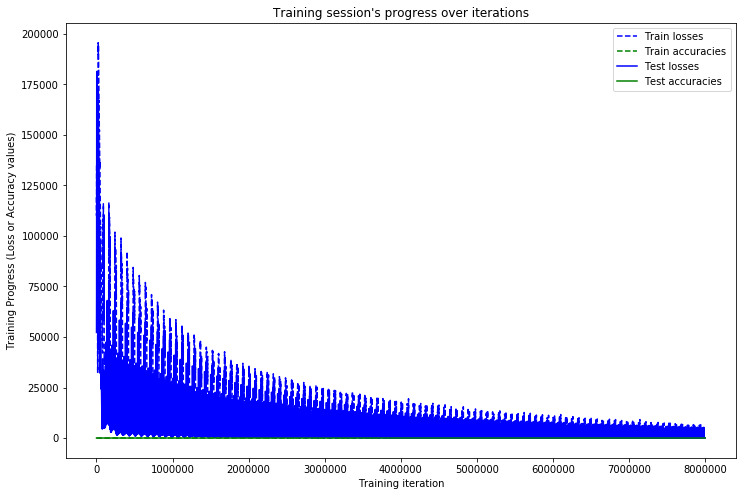

In [9]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
width = 12
height = 8
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Testing Accuracy: 99.8000144958%

Precision: 93.3974167034%
Recall: 93.89%
f1_score: 93.2602495814%

Confusion Matrix:
[[    0     7     0     0     0     1     0    10     0     0     0     0
      0]
 [    0   612     0     0    27   107    79    36     0     0     0    50
      0]
 [    0     0   213     0     0     0     0     0     0     0     0     0
      0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
      0]
 [    0   108     0     0  2724    10    35    10     0     0     0     4
      0]
 [    0    36     0     0     2   285     9    16     0     0     0     0
      0]
 [    0     7     0     0     0     0 14486     0     0     0     0     2
      0]
 [    0    42     0     0    34   336    60    34     0     0     0    29
      0]
 [    0     0     0     0     0     0     0     0   132     0     0     0
      0]
 [    0     0     0     0     0     2     0     0     0     0     0     2
      0]
 [    0     0     0     0     0     0     0     0  

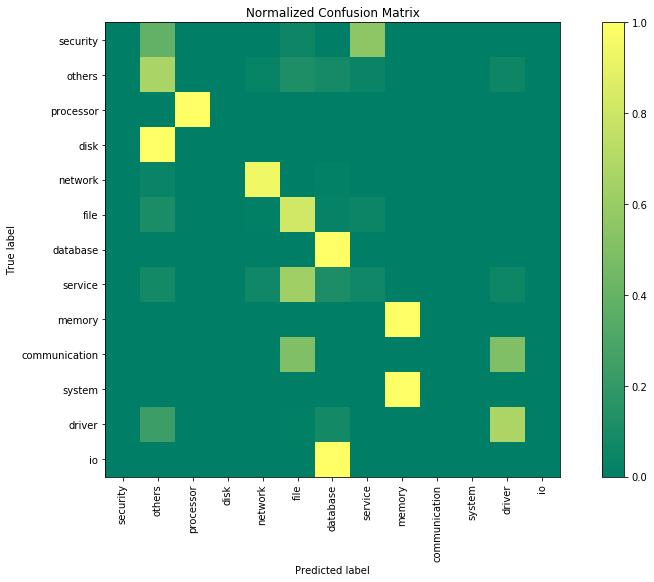

In [11]:
# Results
predictions = []
length = len(test_predictions)-20
for i in range(20):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Testing Accuracy: {}%".format(100*max(test_accuracies)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)